# Obtaining Learning Curves for Sherbrooke and Kyoto Performance

## Sherbrooke PPO Training

In [4]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time
import copy

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from utils import plot_learning
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv
from env_configs import get_sherbrooke_config, get_kyoto_config

from rl_algos.ppo_continuous import PPO_make_train

In [3]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [5]:
# Defining Sherbrooke Params and RL Params

s_config = get_sherbrooke_config()
s_env_config = copy.deepcopy(s_config)

num_envs = 256
num_updates = 5000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": s_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [7]:
env = SinglePhotonLangevinReadoutEnv(**config["ENV_PARAMS"])

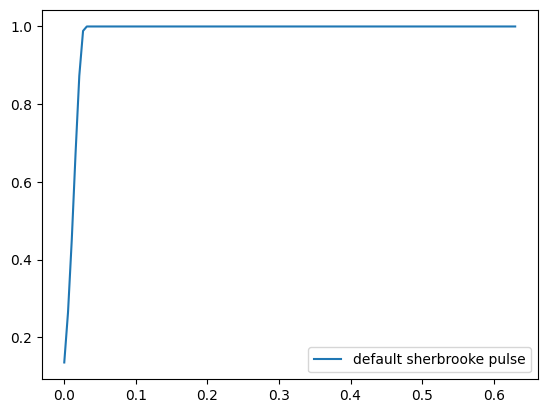

In [8]:
# Default Sherbrooke Action

ts = env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = s_env_config["tau_0"]

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default sherbrooke pulse')
plt.legend()
plt.show()

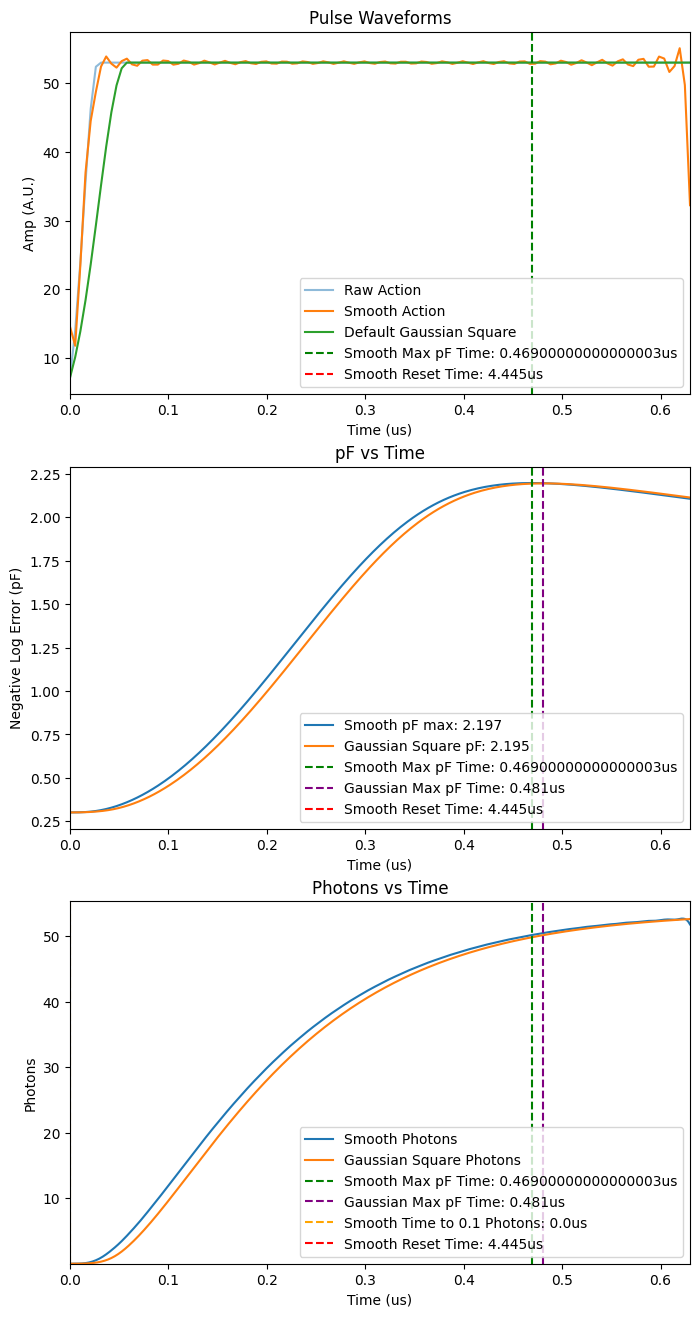

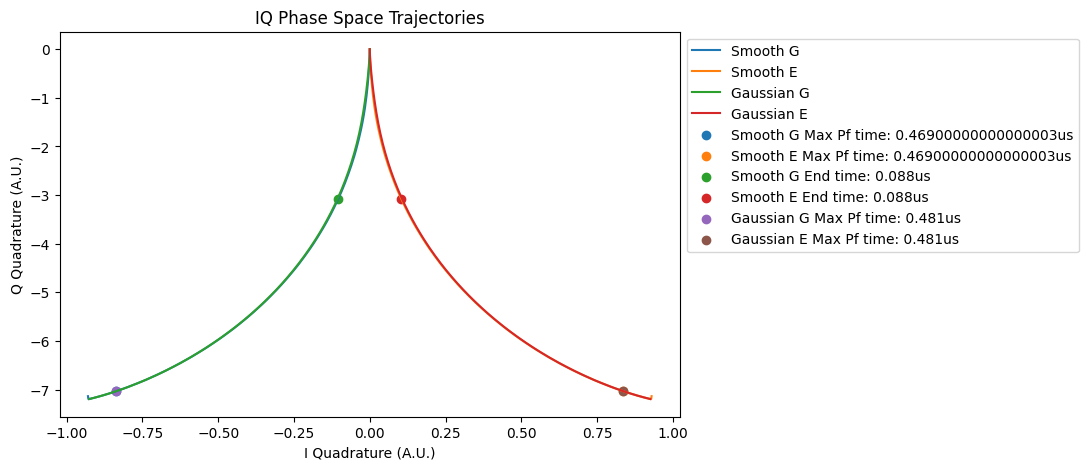

In [9]:
env.rollout_action(_rng, default_pulse)

In [20]:
s_env_config["smoothness_coeff"] = 1.0

config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": s_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [21]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -53.396
max pF: 1.807
max photon: 44.934
photon time: 0.786
smoothness: 0.007991999999999999
bandwidth: 42.054
pulse reset val: 0.271
global update: 200
reward: -51.378
max pF: 1.8820000000000001
max photon: 47.372
photon time: 0.7111000000000001
smoothness: 0.007267999999999999
bandwidth: 40.24
pulse reset val: 0.266
global update: 300
reward: -47.891
max pF: 1.931
max photon: 48.137
photon time: 0.6671
smoothness: 0.006553
bandwidth: 38.869
pulse reset val: 0.246
global update: 400
reward: -45.623
max pF: 1.968
max photon: 48.305
photon time: 0.6792
smoothness: 0.005893
bandwidth: 38.149
pulse reset val: 0.225
global update: 500
reward: -44.305
max pF: 1.987
max photon: 48.414
photon time: 0.6552
smoothness: 0.005059
bandwidth: 35.886
pulse reset val: 0.22
global update: 600
reward: -42.692
max pF: 2.011
max photon: 48.987
photon time: 0.6501
smoothness: 0.005226
bandwidth: 36.2
pulse reset val: 0.214
global update: 700
reward

In [22]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]
amps = metrics["pulse reset val"]

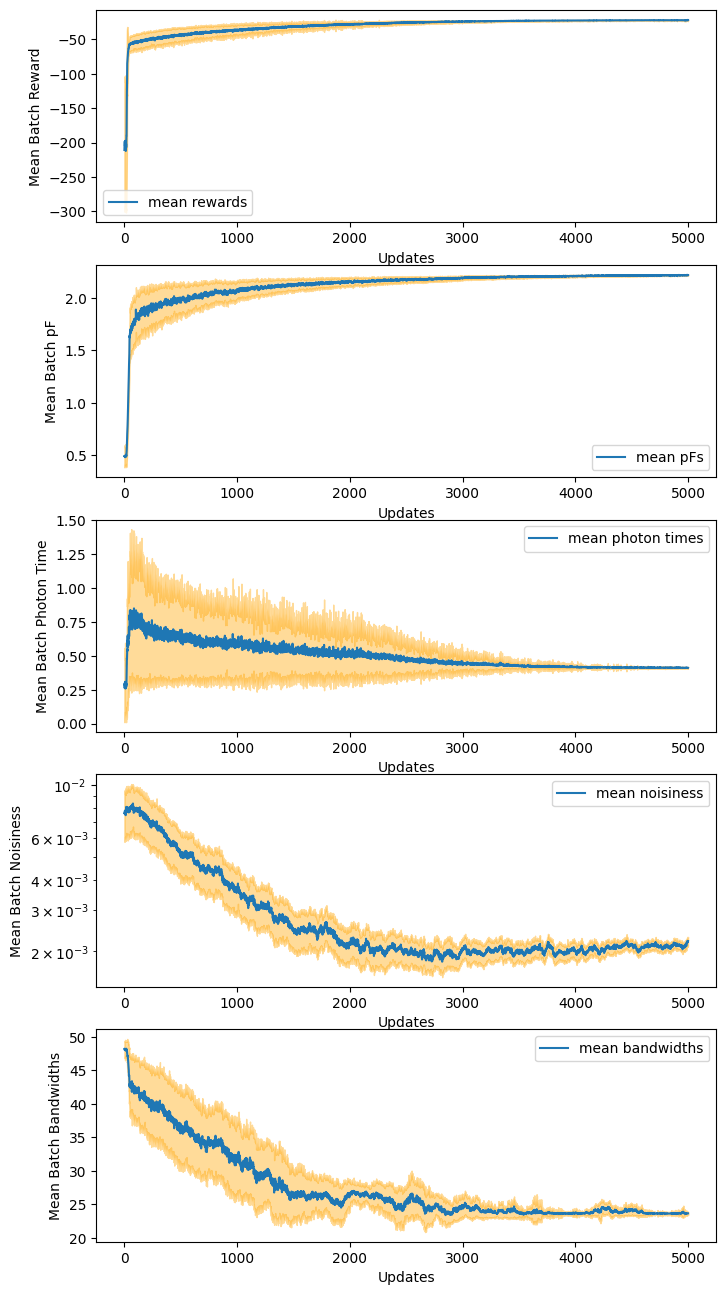

In [23]:
plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

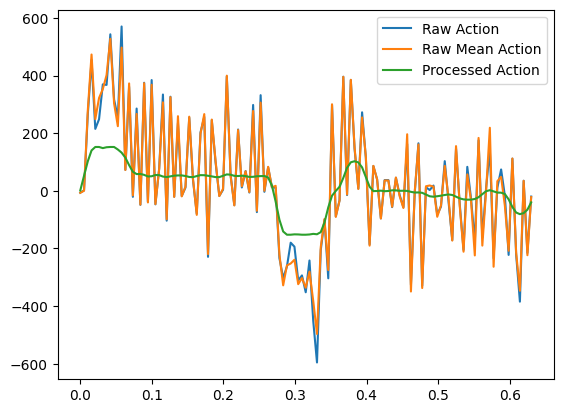

In [24]:
final_action = -actions[-1, 0]
mean_action = jnp.mean(-actions[-1], axis=0)
final_processed_action = env.prepare_action(final_action)

plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(env.ts_action, mean_action * env.a0, label='Raw Mean Action')
plt.plot(env.ts_action, final_processed_action, label='Processed Action')
plt.legend()
plt.show()

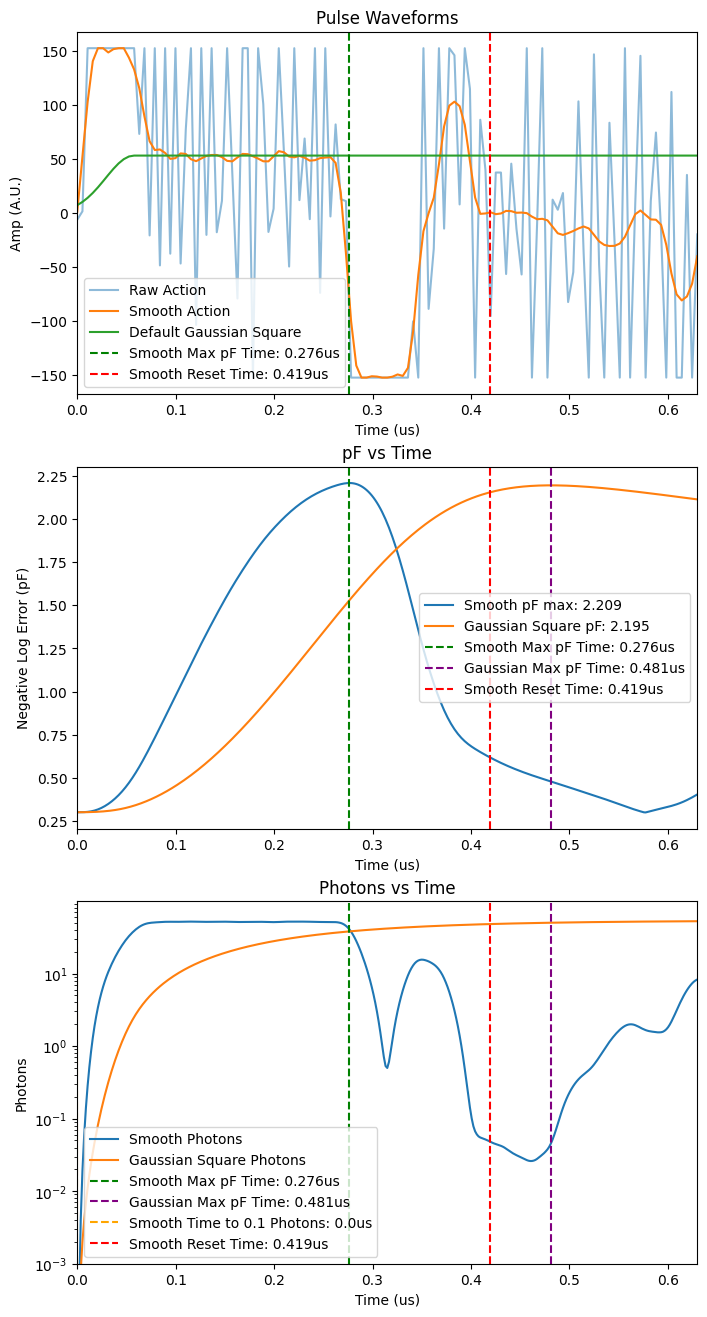

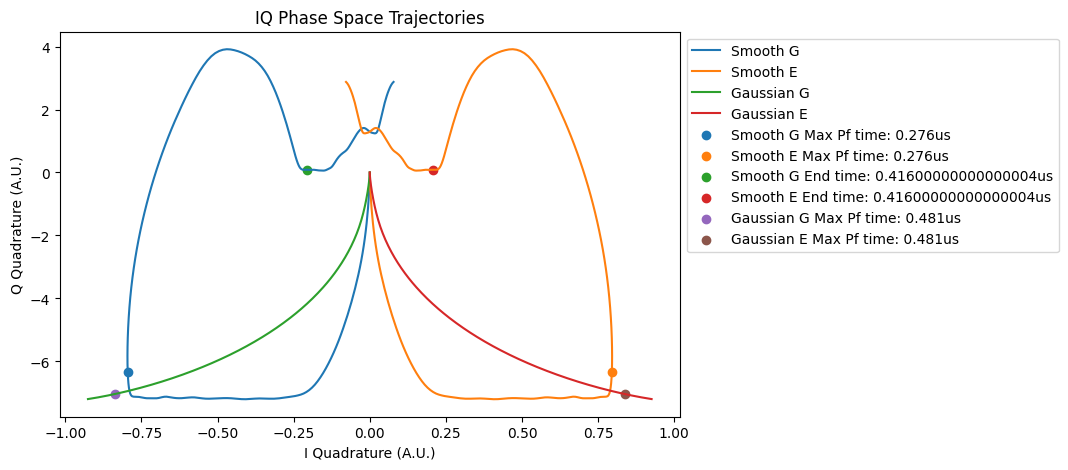

In [25]:
env.rollout_action(_rng, final_action, photon_log_scale=True)

In [87]:
pf_reward = env.pf_reward(max_pFs)
time_reward = env.time_reward(photon_times)
smoothness_reward = env.smoothness_reward(smoothnesses)
amp_reward = env.amp_reward(amps)
photon_penalty = env.photon_pen(max_photons)
opt_action = final_processed_action
action_ts = env.ts_action

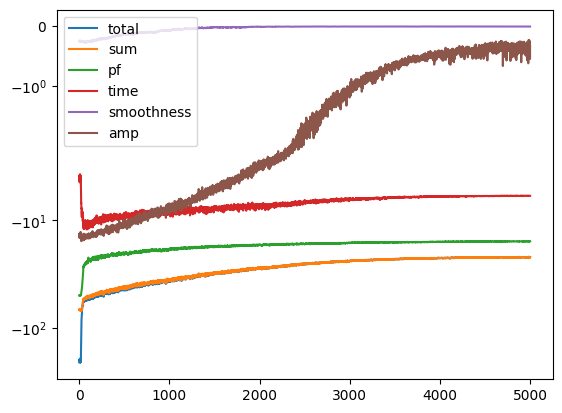

In [90]:
mean_pf_reward = jnp.mean(pf_reward, axis=-1)
mean_time_reward = jnp.mean(time_reward, axis=-1)
mean_smoothness_reward = jnp.mean(smoothness_reward, axis=-1)
mean_amp_reward = jnp.mean(amp_reward, axis=-1)
mean_photon_penalty = jnp.mean(photon_penalty, axis=-1)
mean_sum_reward = mean_pf_reward + mean_time_reward + mean_smoothness_reward + mean_amp_reward - mean_photon_penalty
mean_reward = jnp.mean(rewards, axis=-1)

plt.plot(mean_reward, label='total')
plt.plot(mean_sum_reward, label='sum')
plt.plot(mean_pf_reward, label='pf')
plt.plot(mean_time_reward, label='time')
plt.plot(mean_smoothness_reward, label='smoothness')
plt.plot(mean_amp_reward, label='amp')
plt.legend()
plt.yscale('symlog')
plt.show()

## Kyoto Training

In [34]:
# Defining Kyoto Params and RL Params

k_config = get_kyoto_config()
k_env_config = copy.deepcopy(k_config)

num_envs = 256
num_updates = 5000
kyoto_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": k_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [35]:
kyoto_env = SinglePhotonLangevinReadoutEnv(**k_config)

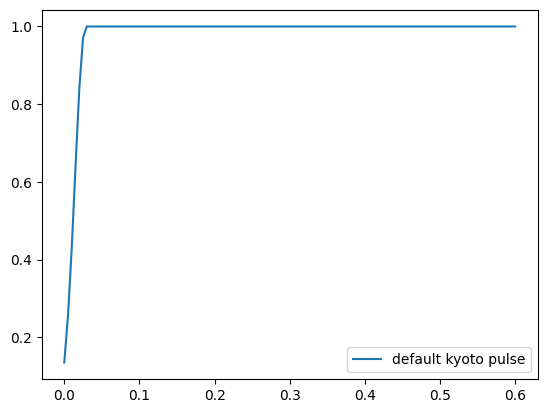

In [36]:
# Default Kyoto Action

ts = kyoto_env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = k_config["tau_0"]

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default kyoto pulse')
plt.legend()
plt.show()

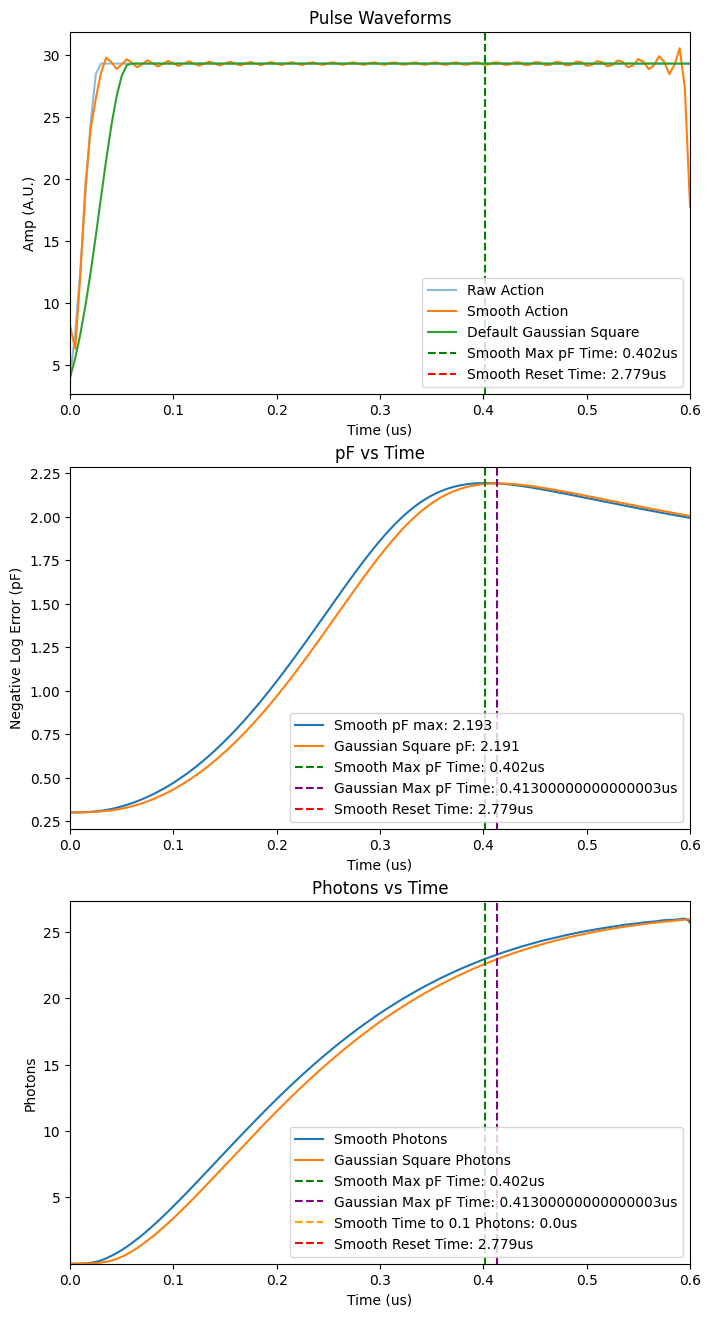

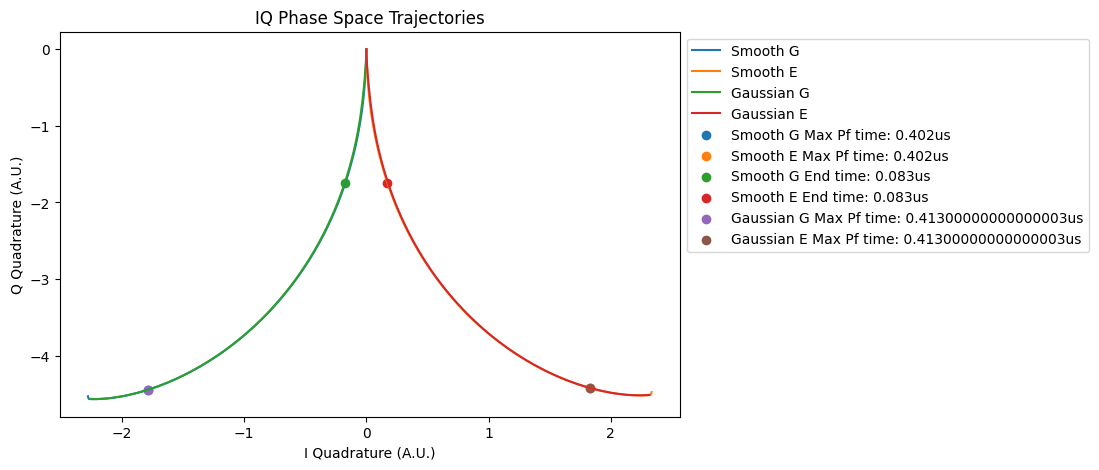

In [37]:
kyoto_env.rollout_action(_rng, default_pulse)

In [61]:
k_env_config["time_coeff"] = 2.0
k_env_config["smoothness_coeff"] = 1.0

k_env_config

{'kappa': 10.07,
 'chi': 5.7805304826052195,
 'kerr': 0.002,
 'time_coeff': 2.0,
 'snr_coeff': 20.0,
 'smoothness_coeff': 1.0,
 'smoothness_baseline_scale': 0.5,
 'gauss_kernel_len': 15,
 'gauss_kernel_std': 2.0,
 'bandwidth': 50.0,
 'freq_relative_cutoff': 0.1,
 'bandwidth_coeff': 0.0,
 'n0': 25.5,
 'tau_0': 0.783,
 'res_amp_scaling': 1.9607843137254901,
 'nR': 0.1,
 'snr_scale_factor': 0.6,
 'gamma_I': 0.0034965034965034965,
 'photon_gamma': 0.0008333333333333334,
 'sim_t1': 0.6,
 'init_fid': 1.0,
 'photon_weight': 8.0,
 'standard_fid': 0.99,
 'shot_noise_std': 0.0}

In [62]:
kyoto_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": k_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [63]:
kyoto_train = jit(PPO_make_train(kyoto_config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
kyoto_result = kyoto_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -58.679
max pF: 2.0420000000000003
max photon: 22.43
photon time: 0.8530000000000001
smoothness: 0.010615
bandwidth: 35.059
pulse reset val: 0.267
global update: 200
reward: -50.838
max pF: 2.118
max photon: 23.849
photon time: 0.791
smoothness: 0.008085
bandwidth: 30.294
pulse reset val: 0.2
global update: 300
reward: -44.671
max pF: 2.136
max photon: 24.588
photon time: 0.6707000000000001
smoothness: 0.006261
bandwidth: 26.989
pulse reset val: 0.17400000000000002
global update: 400
reward: -41.202
max pF: 2.15
max photon: 24.181
photon time: 0.6411
smoothness: 0.005285
bandwidth: 24.412
pulse reset val: 0.14400000000000002
global update: 500
reward: -36.736000000000004
max pF: 2.17
max photon: 24.619
photon time: 0.598
smoothness: 0.004683
bandwidth: 24.483
pulse reset val: 0.095
global update: 600
reward: -34.672000000000004
max pF: 2.177
max photon: 24.628
photon time: 0.5397000000000001
smoothness: 0.004256
bandwidth: 23.09

In [64]:
# Extracting Results

k_metrics = kyoto_result["metrics"]

k_rewards = k_metrics["reward"]
k_max_pFs = k_metrics["max pF"]
k_max_photons = k_metrics["max photon"]
k_photon_times = k_metrics["photon time"]
k_smoothnesses = k_metrics["smoothness"]
k_bandwidths = k_metrics["bandwidth"]
k_actions = k_metrics["action"]
k_amps = k_metrics["pulse reset val"]

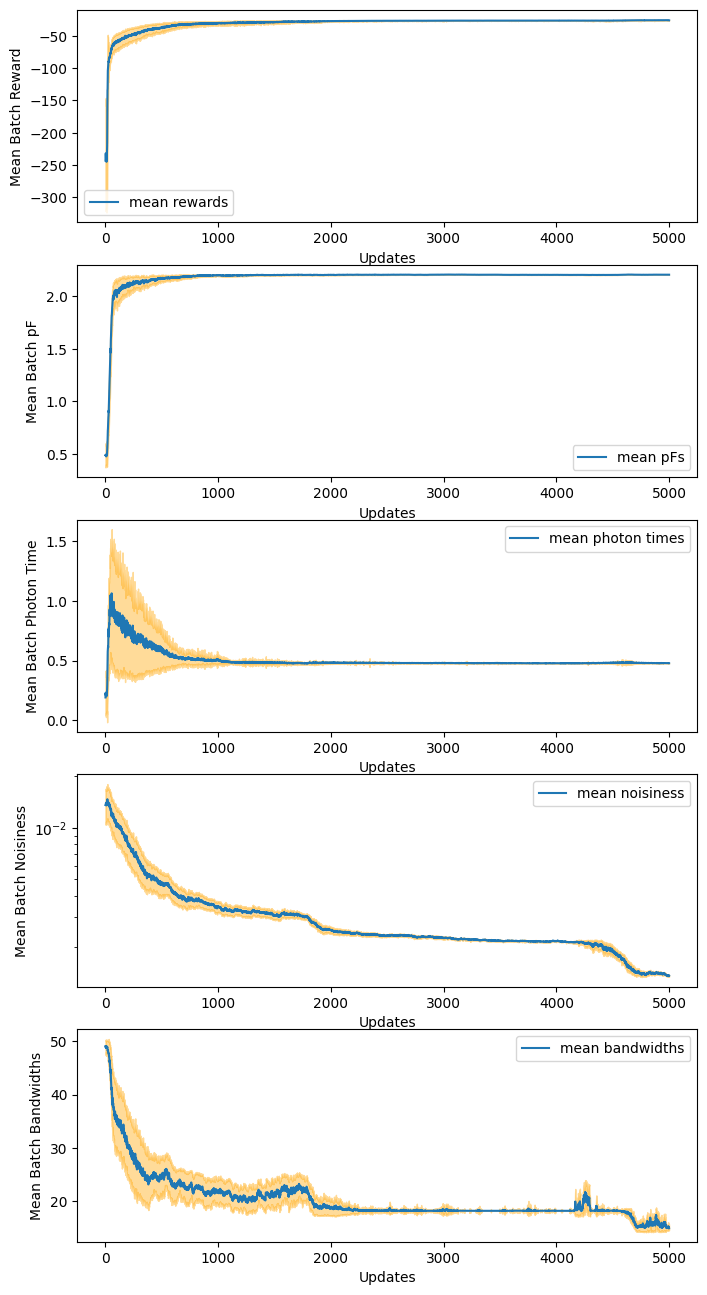

In [65]:
plot_learning(
    rewards=k_rewards,
    max_pFs=k_max_pFs,
    photon_times=k_photon_times,
    smoothnesses=k_smoothnesses,
    bandwidths=k_bandwidths,
)

In [73]:
kyoto_reward_env = SinglePhotonLangevinReadoutEnv(**k_env_config)

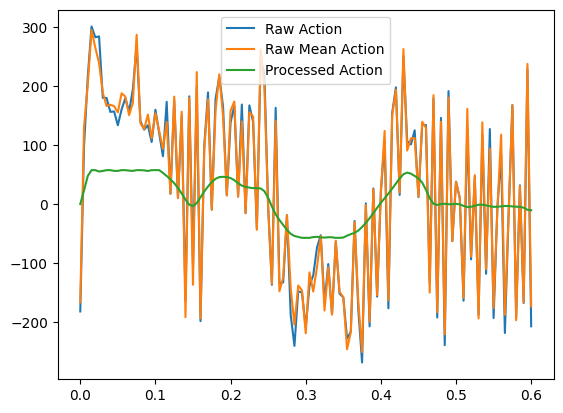

In [74]:
k_final_action = k_actions[-1, 0]
k_mean_action = jnp.mean(k_actions[-1], axis=0)
k_final_processed_action = kyoto_env.prepare_action(k_final_action)

plt.plot(kyoto_env.ts_action, k_final_action * kyoto_env.a0, label='Raw Action')
plt.plot(kyoto_env.ts_action, k_mean_action * kyoto_env.a0, label='Raw Mean Action')
plt.plot(kyoto_env.ts_action, k_final_processed_action, label='Processed Action')
plt.legend()
plt.show()

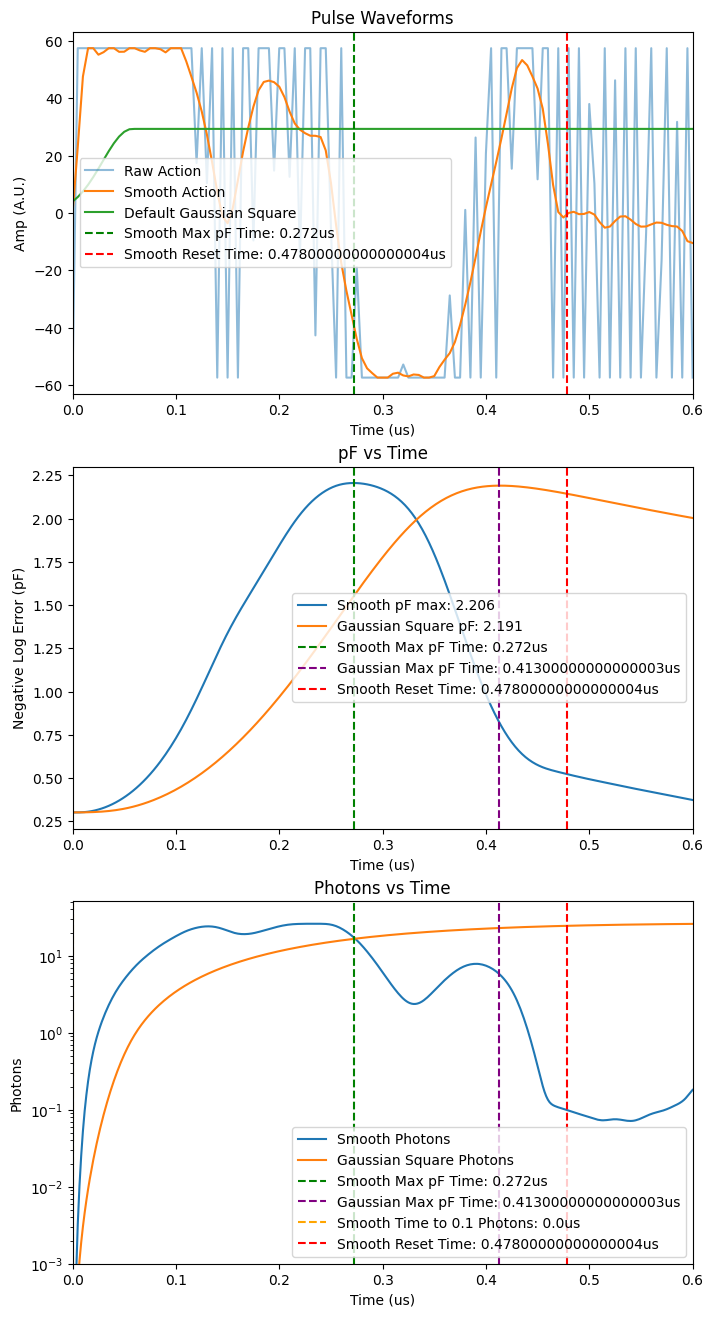

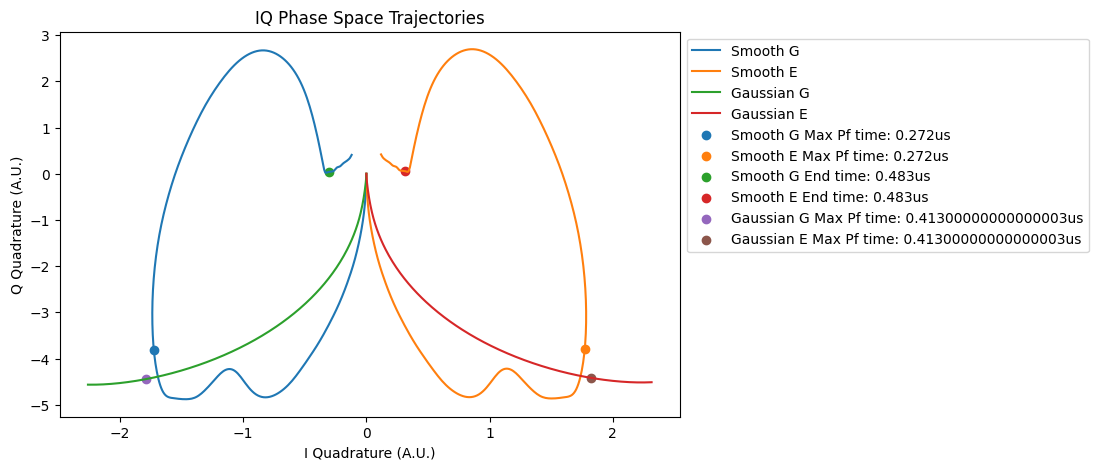

In [75]:
kyoto_reward_env.rollout_action(_rng, k_final_action, photon_log_scale=True)

In [86]:
k_pf_reward = kyoto_reward_env.pf_reward(k_max_pFs)
k_time_reward = kyoto_reward_env.time_reward(k_photon_times)
k_smoothness_reward = kyoto_reward_env.smoothness_reward(k_smoothnesses)
k_amp_reward = kyoto_reward_env.amp_reward(k_amps)
k_photon_penalty = kyoto_reward_env.photon_pen(k_max_photons)
print(k_photon_penalty[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0.         0.         0.         ... 0.00526266 0.00214749 0.00862785]


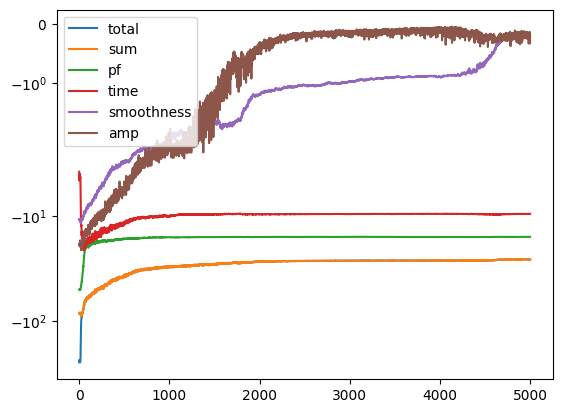

In [91]:
k_mean_pf_reward = jnp.mean(k_pf_reward, axis=-1)
k_mean_time_reward = jnp.mean(k_time_reward, axis=-1)
k_mean_smoothness_reward = jnp.mean(k_smoothness_reward, axis=-1)
k_mean_amp_reward = jnp.mean(k_amp_reward, axis=-1)
k_mean_photon_penalty = jnp.mean(k_photon_penalty, axis=-1)
print(k_mean_photon_penalty)
k_mean_sum_reward = k_mean_pf_reward + k_mean_time_reward + k_mean_smoothness_reward + k_mean_amp_reward - k_mean_photon_penalty
k_mean_reward = jnp.mean(k_rewards, axis=-1)

plt.plot(k_mean_reward, label='total')
plt.plot(k_mean_sum_reward, label='sum')
plt.plot(k_mean_pf_reward, label='pf')
plt.plot(k_mean_time_reward, label='time')
plt.plot(k_mean_smoothness_reward, label='smoothness')
plt.plot(k_mean_amp_reward, label='amp')
plt.yscale('symlog')
plt.legend()
plt.show()

In [92]:
# saving sherbrooke data
sherbrooke_reward_array = jnp.concatenate(
    (
        rewards.reshape(1, *rewards.shape),
        pf_reward.reshape(1, *pf_reward.shape),
        time_reward.reshape(1, *time_reward.shape),
        smoothness_reward.reshape(1, *smoothness_reward.shape),
        amp_reward.reshape(1, *amp_reward.shape),
        photon_penalty.reshape(1, *photon_penalty.shape)
    ),
    axis=0
)
np.save("fig 2 sherbrooke rewards", sherbrooke_reward_array)

In [93]:
# saving kyoto data
kyoto_reward_array = jnp.concatenate(
    (
        k_rewards.reshape(1, *k_rewards.shape),
        k_pf_reward.reshape(1, *k_pf_reward.shape),
        k_time_reward.reshape(1, *k_time_reward.shape),
        k_smoothness_reward.reshape(1, *k_smoothness_reward.shape),
        k_amp_reward.reshape(1, *k_amp_reward.shape),
        k_photon_penalty.reshape(1, *k_photon_penalty.shape)
    ),
    axis=0
)
np.save("fig 2 kyoto rewards", kyoto_reward_array)

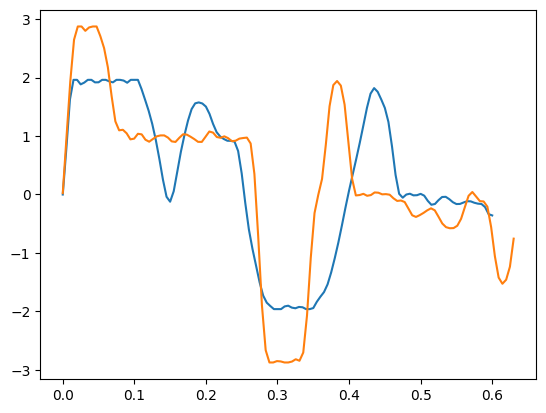

In [94]:
save_kyoto_waveform = k_final_processed_action / kyoto_env.a0
save_sherbrooke_waveform = final_processed_action / env.a0
plt.plot(kyoto_env.ts_action, save_kyoto_waveform)
plt.plot(env.ts_action, save_sherbrooke_waveform)

In [95]:
import pandas as pd

opt_sherbrooke_kyoto_waveforms = jnp.concatenate(
    (
        save_sherbrooke_waveform.reshape(1, -1),
        env.ts_action.reshape(1, -1),
        save_kyoto_waveform.reshape(1, -1),
        kyoto_env.ts_action.reshape(1, -1)
    ),
    axis=0
)
np.save("fig 2 actions", opt_sherbrooke_kyoto_waveforms)